<a href="https://colab.research.google.com/github/SHANMUKHA-VENKAT/SkipGram-word2vec/blob/master/17075036.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Artificial Intelligence Lab 2019: Word2Vec Assignment**

Hello Junta! In this Assignment you will be training your own word vectors. To this end, you will be using Word2Vec technique proposed by Tomas Mikolov (and others) at Google. 
Pre-requisites:
 - Word2Vec Basics
 - Neural Networks
 - Know-how aboutTensorflow, Numpy and MatplotLib

Well there are two methods for word2vec: Skip-Gram and CBOW. In this assignment, you will be working on SkipGram.

I expect you integrity on your side while doing this assignment.  Ans please do not modify the code (for submission) unless explicitely stated.

Enter Your 
- Name : Narayana Shanmukha Venkat
- Roll : 17075036


All the Best!

# import all the necessary libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


from tqdm import tqdm
# tqdm is used in this code for progress bar which you will see while training.
import numpy as np

np.random.seed(12345)
from tensorflow import set_random_seed
set_random_seed(12345)

# DataReader

In [0]:
class DataReader:
    """The data you will be using for this assignment is PennTreebank Data (which has been provided saperately)."""
    NEGATIVE_TABLE_SIZE = 1e8

    def __init__(self, inputFileName, min_count):

        self.negatives = []
        self.discards = []
        self.negpos = 0

        self.word2id = dict() # Maps words to indexes
        self.id2word = dict() # Maps indexes to words
        self.sentences_count = 0 # stores the number of sentences in the corpus
        self.token_count = 0 # stores the number of tokens in the corpus
        self.word_frequency = dict() # Maps words indices to how many times they occur in the corpus. This dictionary will be helpful later when you update 'word2id' and 'id2word'
        # But NOTE <self.word_frequency> is a mapping from INDICES, not words.

        self.inputFileName = inputFileName
        self.read_words(min_count) 
        self.initTableNegatives()
        self.initTableDiscards()

    def read_words(self, min_count):
        """Do not return anything from this function. Motive here is to update the dictionaries word2id and id2word.
             - first update the word_frequency dictionary.
        """
        word_frequency = dict()
        for line in open(self.inputFileName, encoding="utf8"):
            ### YOUR CODE STARTS HERE
            # lowercase the text. split it on white_spaces
            # keep updating the sentences_count, token_count, word_frequency as you go
            
            line = line.lower()
            self.sentences_count += 1
            for w in line.split():
                if len(w) > 0:
                    self.token_count += 1
                    word_frequency[w] = word_frequency.get(w, 0) + 1

                    if self.token_count % 1000000 == 0:
                        print("Read " + str(int(self.token_count / 1000000)) + "M words.")

            
            ### YOUR CODE ENDS HERE
            # Uncomment these lines and feel free to bring them in your loop of data_reading, to keep track of how much data is read
            # if self.token_count % 1000000 == 0:
            #     print("Read " + str(int(self.token_count / 100000)) + "M words.")

        wid = 0
        for w, c in word_frequency.items():
            ### YOUR CODE STARTS HERE
            # do nothing if the word_frequency (c) is less than min_count
            # update the word2id and id2word using w and wid.
            # accordingly update the self.word_frequency as you go; Note that <wid> goes in the keys of this dictionary.
            if c < min_count:
                continue
            self.id2word[wid] = w
            self.word2id[w] = wid
            self.word_frequency[wid] = c
            wid += 1
            
            ### YOUR CODE ENDS HERE
        print("Total embeddings: " + str(len(self.word2id)))

    def initTableDiscards(self):
        t = 0.0001
        f = np.array(list(self.word_frequency.values())) / self.token_count
        self.discards = np.sqrt(t / f) + (t / f)

    def initTableNegatives(self):
        # Remember the negative sampling part. 
        # You already calculated the self.word_frequency
        # Now raise all these frequencies to a power of 0.5
        # normalize the them by their sum: store it in ratio.
        ratio = None
        
        ### YOUR CODE STARTS HERE
        powered_frequency_list = np.array(list(self.word_frequency.values())) ** 0.5
        ratio = powered_frequency_list / sum(powered_frequency_list)
        ### YOUR CODE ENDS HERE
        
        count = np.round(ratio * DataReader.NEGATIVE_TABLE_SIZE)
        
        # We prepare the negatives list using the above parameters for negative sampling.
        for wid, c in enumerate(count):
            self.negatives += [wid] * int(c)
        
        ### YOUR CODE STARTS HERE
        self.negatives = np.array(self.negatives)
        np.random.shuffle(self.negatives)
        ### YOUR CODE ENDS HERE

    def getNegatives(self, target, size):
        response = self.negatives[self.negpos:self.negpos + size]
        self.negpos = (self.negpos + size) % len(self.negatives)
        if len(response) != size:
            return np.concatenate((response, self.negatives[0:self.negpos]))
        return response

In [0]:
class Word2vecDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.input_file = open(data.inputFileName, encoding="utf8")

    def __len__(self):
        return self.data.sentences_count

    def __getitem__(self, idx):
        while True:
            line = self.input_file.readline()
            if not line:
                self.input_file.seek(0, 0)
                line = self.input_file.readline()

            if len(line) > 1:
                words = line.split()

                if len(words) > 1:
                    word_ids = [self.data.word2id[w] for w in words if
                                w in self.data.word2id and np.random.rand() < self.data.discards[self.data.word2id[w]]]

                    boundary = np.random.randint(1, self.window_size)
                    return [(u, v, self.data.getNegatives(v, 5)) for i, u in enumerate(word_ids) for j, v in
                            enumerate(word_ids[max(i - boundary, 0):i + boundary]) if u != v]

    @staticmethod
    def collate(batches):
        all_u = [u for batch in batches for u, _, _ in batch if len(batch) > 0]
        all_v = [v for batch in batches for _, v, _ in batch if len(batch) > 0]
        all_neg_v = [neg_v for batch in batches for _, _, neg_v in batch if len(batch) > 0]

        return torch.LongTensor(all_u), torch.LongTensor(all_v), torch.LongTensor(all_neg_v)

In [0]:
class Word2VecTrainer:
    def __init__(self, input_file, output_file, emb_dimension=100, batch_size=32, window_size=5, iterations=10,
                 initial_lr=0.001, min_count=5):
        """Please do not change emb_dimension, min_count, output_file. Other wise you might get penalized (automatically by the checker). Feel free to change other params."""
        self.data = DataReader(input_file, min_count)
        dataset = Word2vecDataset(self.data, window_size)
        self.dataloader = DataLoader(dataset, batch_size=batch_size,
                                     shuffle=False, num_workers=0, collate_fn=dataset.collate)

        self.output_file_name = output_file
        self.emb_size = len(self.data.word2id)
        self.emb_dimension = emb_dimension
        self.batch_size = batch_size
        self.iterations = iterations
        self.initial_lr = initial_lr
        self.skip_gram_model = SkipGramModel(self.emb_size, self.emb_dimension)

        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        if self.use_cuda:
            self.skip_gram_model.cuda()

    def train(self):
        for iteration in range(self.iterations):
            print("\n\n\nIteration: " + str(iteration + 1))
            optimizer = optim.SparseAdam(self.skip_gram_model.parameters(), lr=self.initial_lr)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(self.dataloader))

            running_loss = 0.0
            for i, sample_batched in enumerate(tqdm(self.dataloader)):
                if len(sample_batched[0]) > 1:
                    pos_u = sample_batched[0].to(self.device)
                    pos_v = sample_batched[1].to(self.device)
                    neg_v = sample_batched[2].to(self.device)
                    
                    scheduler.step()
                    optimizer.zero_grad()
                    loss = self.skip_gram_model.forward(pos_u, pos_v, neg_v)
                    loss.backward()
                    optimizer.step()

                    running_loss = running_loss * 0.9 + loss.item() * 0.1
                    if i > 0 and i % 500 == 0:
                        print(" Loss: " + str(running_loss))

        self.skip_gram_model.save_embedding(self.data.id2word, self.output_file_name)
        return self.skip_gram_model.embedding_dictionary(self.data.id2word)


In [0]:
class SkipGramModel(nn.Module):
    """This is a pytorch implementation for SkipGram Model. 
       Note here we use two different embeddings 
        u_embedding: Embedding for center word.
        v_embedding: Embedding for neighbor words.
       And finally we save the u_embedding as the word vectors. But Note that you are free to experiment with using the v_embeddings/ or averaging them both.
    """
    
    def __init__(self, emb_size, emb_dimension):
        """Here you define the layers of the model."""
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings, self.v_embeddings = None, None
        ### YOUR CODE STARTS HERE
        # initialize the u_embeddings, v_embeddings with Embedding layer from Pytorch. 
        # refer https://pytorch.org/docs/stable/nn.html#sparse-layers
        # *** NOTE: keep the sparse parameter of the layer True
        # set the dimension of them both to (emb_size, emb_dimension)

        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        
        ### YOUR CODE ENDS HERE

        initrange = 1.0 / self.emb_dimension
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)
        init.constant_(self.v_embeddings.weight.data, 0)

    def forward(self, pos_u, pos_v, neg_v):
        """Here you define how the layers process the input of the neural network.
        Return the sum of <score> and <negative score>
        """
        # the tensors pos_u, pos_v, neg_v contain the indices of the words
        # now you need to map these indices to their word_embeddings
        # simply pass these above tensors through the u_embeddings and v_embeddings layers and store the result in the following variables. Do not reshape them.
        # And that's it. Pretty easy isn't  (^_^')
        
        emb_u, emb_v, emb_neg_v = None, None, None
        ### YOUR CODE STARTS HERE
        
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)
        
        ### YOUR CODE ENDS HERE  
        
        # now take the dot product of the emb_u and emb_v, clamp the score and normalize it through softmax.
        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)
        
        #  the following piece of code calculated the negative sampling score
        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score), dim=1)

        return torch.mean(score + neg_score)

    def save_embedding(self, id2word, file_name):
        embedding = self.u_embeddings.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_dimension))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))
    
    def embedding_dictionary(self, id2word):
        embedding = self.u_embeddings.weight.cpu().data.numpy()
        E = {}
        for wid, w in id2word.items():
            E[w] = embedding[wid]
        return E

In [7]:
# Mount your Google Drive Here
from google.colab import drive
drive.mount('/content/gdrive')

# Upload the data files on the Drive
# Set the path to the "polarity.pkl" file
data_path = "gdrive/My Drive/polarity.pkl"


# check if the path you want to use for  exists
!cd "gdrive/My Drive/word2vec" & echo "Hello"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Hello
/bin/bash: line 0: cd: gdrive/My Drive/word2vec: No such file or directory


In [8]:
input_file = 'gdrive/My Drive/PTBclean.txt'
w2v = Word2VecTrainer(input_file=input_file, output_file="out.vec")
vectors = w2v.train()

Total embeddings: 4487


  1%|          | 7/739 [00:00<00:11, 66.25it/s]




Iteration: 1


 69%|██████▉   | 510/739 [00:07<00:03, 73.36it/s]

 Loss: 3.707456116543185


  1%|          | 7/739 [00:00<00:11, 62.56it/s]




Iteration: 2


 70%|██████▉   | 515/739 [00:07<00:03, 72.00it/s]

 Loss: 3.2406104540521494


  1%|          | 7/739 [00:00<00:11, 65.77it/s]




Iteration: 3


 70%|██████▉   | 515/739 [00:07<00:03, 73.42it/s]

 Loss: 2.9928037703632886


  1%|          | 7/739 [00:00<00:12, 59.90it/s]




Iteration: 4


 69%|██████▉   | 509/739 [00:06<00:03, 74.96it/s]

 Loss: 2.8868987894962816


  1%|          | 8/739 [00:00<00:09, 74.11it/s]




Iteration: 5


 69%|██████▉   | 509/739 [00:07<00:03, 72.73it/s]

 Loss: 2.8267869576960845


  1%|          | 7/739 [00:00<00:10, 68.10it/s]




Iteration: 6


 69%|██████▉   | 509/739 [00:06<00:03, 73.57it/s]

 Loss: 2.766704698791863


  1%|          | 8/739 [00:00<00:10, 72.84it/s]




Iteration: 7


 69%|██████▉   | 512/739 [00:06<00:03, 75.19it/s]

 Loss: 2.7358079956575967


  1%|          | 8/739 [00:00<00:10, 71.32it/s]




Iteration: 8


 70%|██████▉   | 515/739 [00:06<00:03, 73.32it/s]

 Loss: 2.699772361863685


  1%|          | 8/739 [00:00<00:10, 72.09it/s]




Iteration: 9


 70%|██████▉   | 515/739 [00:06<00:02, 75.58it/s]

 Loss: 2.6604878783248265


  1%|          | 8/739 [00:00<00:09, 73.48it/s]




Iteration: 10


 70%|███████   | 520/739 [00:06<00:02, 84.39it/s]

 Loss: 2.68866715342172


100%|██████████| 739/739 [00:09<00:00, 74.18it/s]


# Visualize your vectors

In [9]:
print(vectors['is'])

[ 0.08327655 -0.06465846  0.07731729 -0.02627495 -0.05345292 -0.06204605
 -0.05429661  0.06235377 -0.05870133  0.0950086   0.03880911  0.0715967
  0.05601985  0.09041788 -0.06442855 -0.04428674 -0.06773079 -0.01808022
  0.02482437 -0.11535365 -0.08372795  0.08389358  0.05334435  0.06869959
 -0.03140078  0.0710893  -0.03604905  0.07418153 -0.07196469 -0.06176475
 -0.05916577  0.05566907  0.02862125 -0.04528474  0.01226763 -0.01991124
 -0.06892862 -0.04671647 -0.08352187 -0.05258016  0.04866216  0.08052907
 -0.04682224 -0.06365536 -0.0681692  -0.03767868  0.05861996  0.0539942
  0.06059917 -0.08365571 -0.07653565 -0.09868433  0.09856103  0.07701399
 -0.02827692  0.09128118  0.05811524 -0.04007667  0.00365094 -0.0299638
  0.09596469  0.06692669 -0.06587201  0.09267444  0.06228261  0.04927918
  0.0439609  -0.06128385 -0.07278035  0.12482908 -0.08201605  0.06444329
 -0.12446178 -0.05977924 -0.05795981 -0.08257019 -0.03675573  0.07518455
  0.09716192  0.06552763  0.06371452  0.06031176  0.04

cat
[0.011262456886470318, -0.016896279528737068, 0.011470533907413483, -0.006318163126707077, -0.0030332286842167377, -0.009637177921831608, -0.0032776412554085255, 0.021074824035167694, -0.010111209936439991, 0.013182228431105614, 0.018292222172021866, 0.005568765103816986, 0.013900133781135082, 0.012405448593199253, -0.022972526028752327, -0.01998080126941204, -0.01566762663424015, -0.00893367175012827, 0.005097092129290104, -0.003047030884772539, -0.015960508957505226, 0.0038710683584213257, 0.020978868007659912, 0.01063678227365017, -0.010502125136554241, 0.006686170119792223, -0.0017585186287760735, 0.01567201130092144, -0.01047380082309246, -0.0044497339986264706, -0.013111229985952377, 0.011917724274098873, 0.00913666095584631, -0.014782913960516453, 0.015740258619189262, -0.013865184038877487, -0.017297767102718353, -0.007566735614091158, -0.00914730317890644, -0.017680050805211067, 0.00611748406663537, 0.008978700265288353, -0.004375886172056198, -0.012217050418257713, -0.022

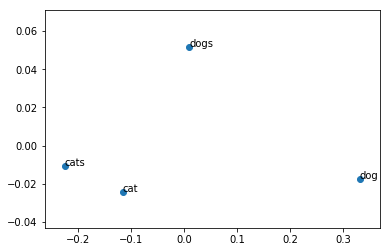

In [10]:
# Here we use PCS to plot the relatios between 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Choose Your Favourite list of words, or make a new list on your own
Favourites = ['Men','Women','King','Queen','boy','girl']
Favourites = ['cat','cats','dog','dogs']
# NOTE: You MIGHT not be ablt to see the word relations in the plot. This may be due to small amount of training data and dimentionality reduction

Favourites = [i.lower() for i in Favourites]
Vectors = [vectors[w] if w in vectors else np.zeros_like(vectors['a']) for w in Favourites]
for w,v in zip(Favourites[:2],Vectors[:2]):
    print( "{}\n{}\n".format(w,v.tolist()) )
    break
    
# Visualize these vectors on your own in 2d
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(np.asarray(Vectors))

z, y = vectors_2d[:,0], vectors_2d[:,1]
labels = Favourites
fig, ax = plt.subplots()
ax.scatter(z, y)
for i, txt in enumerate(labels):
    ax.annotate(txt, (z[i], y[i]))

# Evaluation Time

There are two ways to evaluate word vectors:
 - Intrinsic evaluation : Evaluate the vectors by retrieving similar words from the vocabulary.
 - Extrinsic Evaluation : Evaluate the vectors by using them to train a model on a downstream task.
 
 In this assignment we will do some extrinsic evaluation, here, the downstream task being Polarity classification.
 Don't worry you don't need to write any code here. Just follow the code and run the cells.
 Make sure that you go through the CNN Model -> fit() function. It is the heart of the keras CNN code for text processing.

In [11]:
# PLEASE DO NOT MODIFY THIS CODE
# Load Polarity Data
data_dir = 'gdrive/My Drive/'
import pickle
all_data = pickle.load(open(data_dir+'polarity.pkl', 'rb'))

data = [d.lower() for d in all_data['data']]
labels = all_data['labels']
label_names = all_data['label_names']
val = [d.lower() for d in all_data['imdb']]
val_labels = all_data['imdb_labels']
print(len(data), len(val))


10433 1000


In [12]:
# PLEASE DO NOT MODIFY THIS CODE
import keras
from keras.preprocessing import sequence
import keras.preprocessing.text
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.datasets import imdb
import tempfile
from keras import backend as K


def get_most_common_embeddings_glove(tokenizer, glove):
    import operator
    most_common = list(map(operator.itemgetter(0), sorted(tokenizer.word_index.items(), key=operator.itemgetter(1))))
    n = len(tokenizer.word_index)
    if tokenizer.num_words is not None:
        most_common = most_common[:tokenizer.num_words]
        n = min(tokenizer.num_words, n)
    embeddings = np.zeros((n + 1, glove['is'].shape[0]), dtype='float32')
    for i, lex in enumerate(most_common):
        if lex in glove :
            embeddings[i + 1] = glove[lex]
    return embeddings

class CNNClassifier:
    def __init__(self, glove):
        self.glove = glove
        pass  
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    def predict_proba(self, X):
        x_test = self.tokenizer.texts_to_sequences(X)
        x_test = sequence.pad_sequences(x_test, maxlen=self.maxlen)
        a = self.model.predict(x_test, verbose=0).flatten()
        a = a.reshape(-1, 1)
        return np.hstack((1 - a, a))
    def fit(self, X, Y, max_features=20000, maxlen=400,
            batch_size=32, hidden_dims=250, filters=250, kernel_size=3,
            epochs=5):
        from keras.preprocessing import sequence
        from keras.models import Sequential
        from keras.layers import Dense, Dropout, Activation
        from keras.layers import Embedding
        from keras.layers import Conv1D, GlobalMaxPooling1D
        self.tokenizer = keras.preprocessing.text.Tokenizer(
            num_words=max_features, split=" ", char_level=False)
        self.tokenizer.fit_on_texts(X)
        x_train = self.tokenizer.texts_to_sequences(X)
        self.maxlen = maxlen
#         embeddings = get_most_common_embeddings(self.tokenizer, self.nlp)
        embeddings = get_most_common_embeddings_glove(self.tokenizer, self.glove)
        x_train = sequence.pad_sequences(x_train, maxlen=self.maxlen)
        self.model = Sequential()
        # we start off with an efficient embedding layer which maps
        # our vocab indices into embedding_dims dimensions
        self.model.add(
            Embedding(
                embeddings.shape[0],
                embeddings.shape[1],
                input_length=maxlen,
                trainable=False,
                weights=[embeddings]
            )
        )

        self.model.add(Dropout(0.2))

        # we add a Convolution1D, which will learn filters
        # word group filters of size filter_length:
        self.model.add(Conv1D(filters, kernel_size, padding='valid',
                              activation='relu', strides=1))
        # we use max pooling:
        self.model.add(GlobalMaxPooling1D())

        # We add a vanilla hidden layer:
        self.model.add(Dense(hidden_dims))
        self.model.add(Dropout(0.2))
        self.model.add(Activation('relu'))
        # We project onto a single unit output layer, and squash it with a sigmoid:
        self.model.add(Dense(1))
        # model.add(Dense(3))
        self.model.add(Activation('sigmoid'))



        # optimizer = keras.optimizers.Adam(lr=0.001)
        optimizer = keras.optimizers.Adam(lr=0.0001)
        # model.compile(loss='categorical_crossentropy',
        #               optimizer=optimizer,
        #               metrics=['accuracy'])
        self.model.compile(loss='binary_crossentropy',
                           optimizer=optimizer,
                           metrics=['accuracy'])

        self.model.fit(x_train, Y, batch_size=batch_size, epochs=epochs, verbose=2)


Using TensorFlow backend.


In [13]:
cnnmodel = CNNClassifier(vectors)
cnnmodel.fit(data, labels, epochs=50, maxlen=100)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
 - 11s - loss: 0.6824 - acc: 0.5656
Epoch 2/50
 - 11s - loss: 0.6730 - acc: 0.5856
Epoch 3/50
 - 11s - loss: 0.6677 - acc: 0.5909
Epoch 4/50
 - 11s - loss: 0.6664 - acc: 0.5918
Epoch 5/50
 - 10s - loss: 0.6611 - acc: 0.6072
Epoch 6/50
 - 11s - loss: 0.6588 - acc: 0.6020
Epoch 7/50
 - 11s - loss: 0.6557 - acc: 0.6124
Epoch 8/50
 - 11s - loss: 0.6540 - acc: 0.6140
Epoch 9/50
 - 11s - loss: 0.6497 - acc: 0.6173
Epoch 10/50
 - 11s - loss: 0.6459 - acc: 0.6247
Epoch 11/50
 - 11s - loss: 0.6445 - acc: 0.6240
Epoch 12/50
 - 11s - loss: 0.6408 - acc: 0.6294
Epoch 13/50
 - 11s - loss: 0.6401 - acc: 0.6270
Epoch 14/50
 - 11s - loss: 0.6375 - acc: 0.6349
Epoch 15/50
 - 11s - los

In [14]:
val_accuracy = (cnnmodel.predict(val) == val_labels).mean()
print(val_accuracy)

0.611


In [0]:
from google.colab import files
files.download('out.vec')